In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fabric-defect-dataset/FYP/Fabric Defects Dataset/Fabric Defect Dataset/Vertical/20.jpg
/kaggle/input/fabric-defect-dataset/FYP/Fabric Defects Dataset/Fabric Defect Dataset/Vertical/6.jpg
/kaggle/input/fabric-defect-dataset/FYP/Fabric Defects Dataset/Fabric Defect Dataset/Vertical/5_processed (3).jpg
/kaggle/input/fabric-defect-dataset/FYP/Fabric Defects Dataset/Fabric Defect Dataset/Vertical/7_processed (1).jpg
/kaggle/input/fabric-defect-dataset/FYP/Fabric Defects Dataset/Fabric Defect Dataset/Vertical/7_processed (2).jpg
/kaggle/input/fabric-defect-dataset/FYP/Fabric Defects Dataset/Fabric Defect Dataset/Vertical/4_processed(3).jpg
/kaggle/input/fabric-defect-dataset/FYP/Fabric Defects Dataset/Fabric Defect Dataset/Vertical/5.jpg
/kaggle/input/fabric-defect-dataset/FYP/Fabric Defects Dataset/Fabric Defect Dataset/Vertical/8.jpg
/kaggle/input/fabric-defect-dataset/FYP/Fabric Defects Dataset/Fabric Defect Dataset/Vertical/9_processed (2).jpg
/kaggle/input/fabric-defect-da

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset, random_split
from torchvision import models, transforms
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from torch.optim.lr_scheduler import CosineAnnealingLR
from collections import Counter
from sklearn.manifold import TSNE

In [3]:
class FabricDefectDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.images = self._load_images()

    def _load_images(self):
        images = []
        for cls in self.classes:
            cls_dir = os.path.join(self.root_dir, cls)
            for img_name in os.listdir(cls_dir):
                img_path = os.path.join(cls_dir, img_name)
                images.append((img_path, self.class_to_idx[cls]))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
dataset = FabricDefectDataset(root_dir='/kaggle/input/fabric-defect-dataset/FYP/Fabric Defects Dataset/Fabric Defect Dataset', transform=transform)

In [6]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [ ]:
import random

def oversample_dataset(dataset):
    # Get the labels and counts for each class
    labels = [label for _, label in dataset]
    class_counts = Counter(labels)
    max_count = max(class_counts.values())

    # Create a list to store oversampled data
    oversampled_data = []

    # Oversample each class
    for class_idx, count in class_counts.items():
        # Get all samples for the current class
        class_samples = [data for data in dataset if data[1] == class_idx]
        
        # Randomly duplicate samples to match the max count
        oversampled_data.extend(class_samples)
        if count < max_count:
            # Randomly select samples to duplicate
            oversampled_data.extend(random.choices(class_samples, k=max_count - count))

    return oversampled_data

# Apply oversampling to the training set
train_dataset = oversample_dataset(train_dataset)

In [8]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 166MB/s] 


In [10]:
for param in model.parameters():
    param.requires_grad = True  # Unfreeze all layers

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(dataset.classes))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [11]:
criterion = nn.CrossEntropyLoss()

In [12]:
optimizer = optim.AdamW(model.parameters(), lr=0.0001)  # Best hyperparameters

In [13]:
scheduler = CosineAnnealingLR(optimizer, T_max=15, eta_min=0.00001)

In [14]:
num_epochs = 15
train_losses, val_losses, train_accs, val_accs = [], [], [], []

Epoch [1/15], Loss: 0.1837, Accuracy: 94.12%
Epoch [2/15], Loss: 0.0321, Accuracy: 98.94%
Epoch [3/15], Loss: 0.0261, Accuracy: 99.10%
Epoch [4/15], Loss: 0.0135, Accuracy: 99.47%
Epoch [5/15], Loss: 0.0083, Accuracy: 99.79%
Epoch [6/15], Loss: 0.0124, Accuracy: 99.56%
Epoch [7/15], Loss: 0.0103, Accuracy: 99.68%
Epoch [8/15], Loss: 0.0046, Accuracy: 99.91%
Epoch [9/15], Loss: 0.0019, Accuracy: 99.96%
Epoch [10/15], Loss: 0.0021, Accuracy: 99.91%
Epoch [11/15], Loss: 0.0007, Accuracy: 100.00%
Epoch [12/15], Loss: 0.0005, Accuracy: 100.00%
Epoch [13/15], Loss: 0.0005, Accuracy: 100.00%
Epoch [14/15], Loss: 0.0007, Accuracy: 99.98%
Epoch [15/15], Loss: 0.0005, Accuracy: 100.00%
Model saved as 'mixeddataset_resnet_oversampling.pth'

Test Loss: 0.0934, Test Accuracy: 97.70%


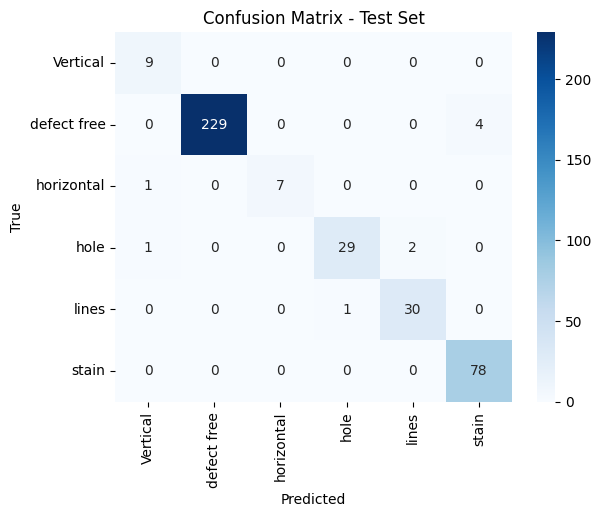

Classification Report - Test Set
              precision    recall  f1-score   support

    Vertical       0.82      1.00      0.90         9
 defect free       1.00      0.98      0.99       233
  horizontal       1.00      0.88      0.93         8
        hole       0.97      0.91      0.94        32
       lines       0.94      0.97      0.95        31
       stain       0.95      1.00      0.97        78

    accuracy                           0.98       391
   macro avg       0.95      0.96      0.95       391
weighted avg       0.98      0.98      0.98       391



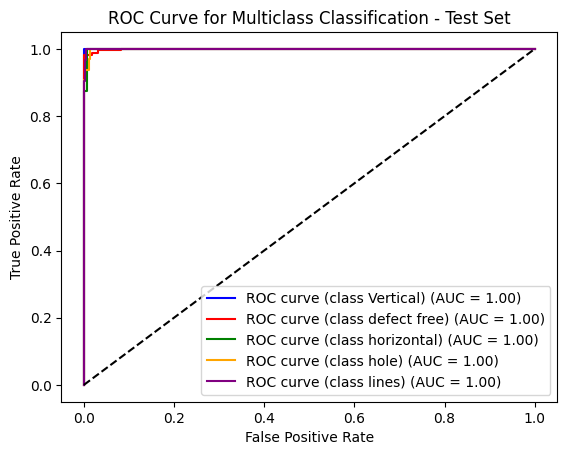


Image Index: 18
True Label: lines
Predicted Label: hole
Class Probabilities: [6.6669396e-05 1.4341725e-03 3.6071102e-05 7.5276065e-01 2.4503566e-01
 6.6679058e-04]


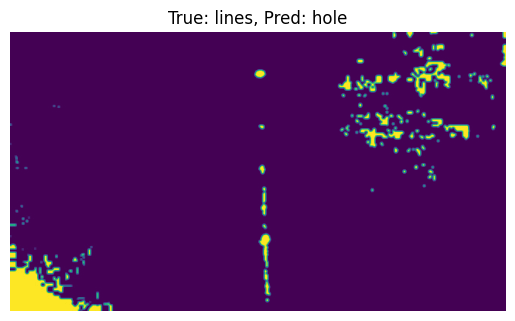


Image Index: 43
True Label: defect free
Predicted Label: stain
Class Probabilities: [8.9317691e-05 6.5335254e-03 1.6192302e-05 7.2487073e-06 2.7383718e-05
 9.9332643e-01]


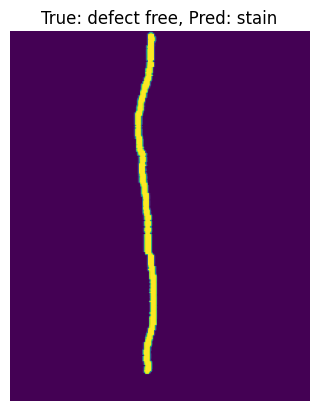


Image Index: 53
True Label: defect free
Predicted Label: stain
Class Probabilities: [4.3988998e-06 1.4203278e-03 8.8047373e-06 1.8740004e-06 1.4054708e-05
 9.9855047e-01]


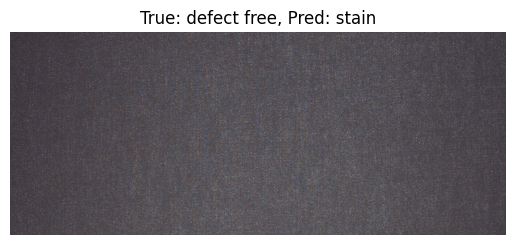


Image Index: 92
True Label: hole
Predicted Label: Vertical
Class Probabilities: [9.1020387e-01 4.8010063e-04 7.4705534e-02 1.2649813e-02 1.1848351e-03
 7.7584916e-04]


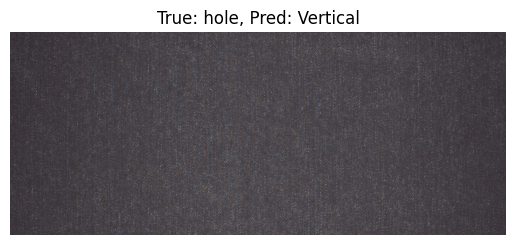


Image Index: 137
True Label: horizontal
Predicted Label: Vertical
Class Probabilities: [9.4698340e-01 8.8473008e-04 8.9779003e-03 4.2299494e-02 7.0776889e-04
 1.4668143e-04]


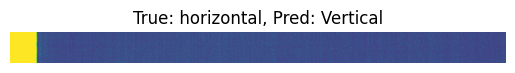


Image Index: 190
True Label: hole
Predicted Label: lines
Class Probabilities: [6.6030836e-05 3.7597300e-05 1.7314305e-05 4.4087986e-03 9.9514836e-01
 3.2180964e-04]


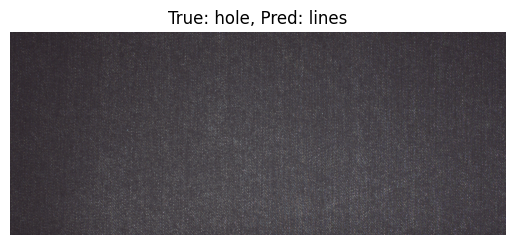


Image Index: 219
True Label: defect free
Predicted Label: stain
Class Probabilities: [9.1887458e-05 1.2882087e-02 2.2586416e-04 6.2766827e-05 2.6475414e-04
 9.8647261e-01]


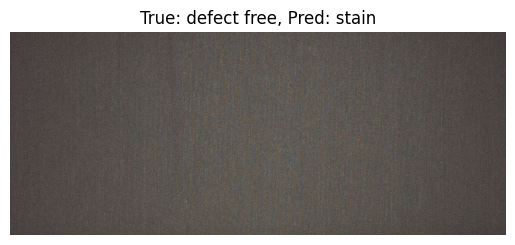


Image Index: 269
True Label: defect free
Predicted Label: stain
Class Probabilities: [1.19075885e-04 8.10642987e-02 2.86258673e-05 1.92854481e-04
 5.94454410e-04 9.18000698e-01]


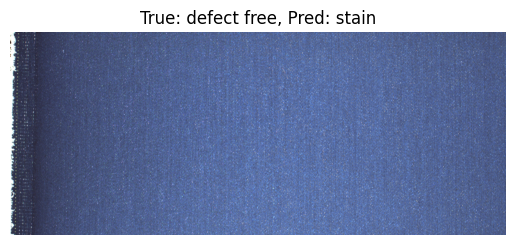


Image Index: 305
True Label: hole
Predicted Label: lines
Class Probabilities: [1.00489787e-03 9.26133769e-04 6.20561827e-04 1.15909345e-01
 8.80958438e-01 5.80617983e-04]


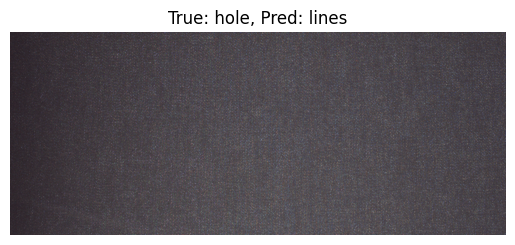

In [15]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%')
    
    # Learning rate scheduler step
    scheduler.step()

# Save the trained model
torch.save(model.state_dict(), 'mixeddataset_resnet_oversampling.pth')
print("Model saved as 'mixeddataset_resnet_oversampling.pth'")

# Evaluate on the test set
model.eval()
test_loss = 0.0
correct = 0
total = 0
true_labels, predicted_labels, predictions = [], [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
        predictions.extend(torch.softmax(outputs, dim=1).cpu().numpy())

test_loss /= len(test_loader)
test_acc = 100. * correct / total

print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.show()

# Classification Report
print("Classification Report - Test Set")
print(classification_report(true_labels, predicted_labels, target_names=dataset.classes))

# ROC/AUC Curve for Multiclass Classification
true_labels_bin = label_binarize(true_labels, classes=np.arange(len(dataset.classes)))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(dataset.classes)):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], np.array(predictions)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = ['blue', 'red', 'green', 'orange', 'purple']  # Add more colors if needed
for i, color in zip(range(len(dataset.classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, label=f'ROC curve (class {dataset.classes[i]}) (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification - Test Set')
plt.legend(loc="lower right")
plt.show()

# Misclassified Images
misclassified_idx = [i for i, (p, t) in enumerate(zip(predicted_labels, true_labels)) if p != t]
for idx in misclassified_idx[:10]:  # Limit to first 10 for visualization
    true_label = dataset.classes[true_labels[idx]]
    predicted_label = dataset.classes[predicted_labels[idx]]
    probabilities = predictions[idx]

    print(f"\nImage Index: {idx}")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {predicted_label}")
    print(f"Class Probabilities: {probabilities}")

    # Visualize the misclassified image
    img = Image.open(dataset.images[idx][0])
    plt.imshow(img)
    plt.title(f"True: {true_label}, Pred: {predicted_label}")
    plt.xlabel(f"Probs: {probabilities}")
    plt.axis('off')
    plt.show()

NameError: name 'test_losses' is not defined

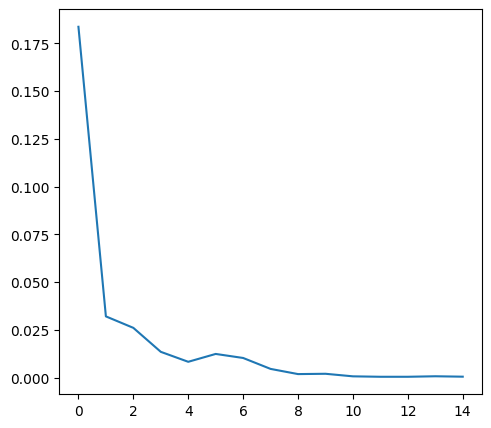

In [16]:
plt.figure(figsize=(12, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy')
plt.legend()

plt.show()

# T-SNE Visualization on Test Set
def extract_embeddings(model, dataloader, device):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            embeddings.extend(outputs.cpu().numpy())
            labels.extend(targets.cpu().numpy())
    return np.array(embeddings), np.array(labels)

# Extract embeddings from the last layer
embeddings, labels = extract_embeddings(model, test_loader, device)

# Apply T-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot T-SNE
plt.figure(figsize=(10, 8))
for i, cls in enumerate(dataset.classes):
    idx = labels == i
    plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], label=cls)
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('T-SNE Visualization of Embeddings (Test Set)')
plt.legend()
plt.show()

In [ ]:
from IPython.display import FileLink

# Create a download link for the file
FileLink(r'mixeddataset_resnet_oversampling.pth')